In [1]:
from google.colab import drive
drive.mount('/content/shared', force_remount=True)

Mounted at /content/shared


In [2]:
!unzip /content/shared/MyDrive/images.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/43.6197857_1.4567143.png  
 extracting: images/43.6198342_1.4740216.png  
  inflating: images/43.619917_1.4069512.png  
  inflating: images/43.6199228_1.4625883.png  
  inflating: images/43.6199673_1.4037257.png  
  inflating: images/43.6199683_1.471763.png  
  inflating: images/43.6200082_1.4609661.png  
  inflating: images/43.6200108_1.4606528.png  
  inflating: images/43.6200623_1.4596186.png  
 extracting: images/43.6200684_1.4138413.png  
 extracting: images/43.6200757_1.4137441.png  
 extracting: images/43.6200892_1.4523681.png  
 extracting: images/43.620104_1.4548037.png  
  inflating: images/43.6201234_1.4602113.png  
 extracting: images/43.6201332_1.4541244.png  
  inflating: images/43.6202266_1.4228669.png  
  inflating: images/43.6203196_1.4446524.png  
  inflating: images/43.6203767_1.4291393.png  
  inflating: images/43.6203858_1.4717425.png  
  inflating: images/43.6204035_1.4260167.png  
 extracting:

In [3]:
!git clone https://github.com/OmarFarag95/minimum-area-bounding-rectangle-python3.git min_bbox

Cloning into 'min_bbox'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 13 (delta 0), reused 3 (delta 0), pack-reused 7
Unpacking objects: 100% (13/13), done.


In [4]:
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
BASE_PATH = "/content"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "metadata.json"])

In [6]:

BASE_OUTPUT = "output"
if not os.path.exists(BASE_OUTPUT):
    os.makedirs(BASE_OUTPUT)
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [7]:
INIT_LR = 1e-4
NUM_EPOCHS = 3
BATCH_SIZE = 16

In [8]:
# import the necessary packages
from tensorflow.keras.applications import VGG16, resnet
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [9]:
!cp shared/MyDrive/metadata.json /content/

In [10]:
def get_bounding_box(points):

    bot_left_x = min(point[0] for point in points)
    bot_left_y = min(point[1] for point in points)
    top_right_x = max(point[0] for point in points)
    top_right_y = max(point[1] for point in points)

    return [(bot_left_x, bot_left_y), (top_right_x, top_right_y)]

In [11]:
from numpy import *

from min_bbox.python.qhull_2d import *
from min_bbox.python.min_bounding_rect import *

def bounding_box_v2(points):
    
    xy_points = array(points)

    hull_points = qhull2D(xy_points)

    # Reverse order of points, to match output from other qhull implementations
    hull_points = hull_points[::-1]

    #print ('Convex hull points: \n', hull_points, "\n")

    # Find minimum area bounding rectangle
    (rot_angle, area, width, height, center_point, corner_points) = minBoundingRect(hull_points)

    return corner_points

In [12]:
v = [[246.09293140559757, 222.41169803156015],[250.44603729904748, 211.9438727322957],
    [283.09433149992174, 279.3110343649168],
    [297.5046130999609, 244.07283583161148],
    [214.5704404561325, 249.46220866382959],
    [233.4088814757176, 204.68894331699937]]

get_bounding_box(bounding_box_v2(v))

[(214.0117703929369, 204.54907251083404),
 (302.5523699359264, 279.3110343649168)]

In [13]:
# load the contents of the json annotations file

import json
with open('metadata.json') as f:
  metadata = json.load(f)

rows = []
set_sizes = []
for k,v in metadata.items():
    tuples_bounds = []
    xy_tuples = list(set([(int(sample['x']),int(sample['y'])) for sample in v["bounds_x_y"]]))
    ## get boundarybox
    if(len(xy_tuples)<4):
      continue
    bbox = get_bounding_box(bounding_box_v2((xy_tuples)))
    rows.append({k:bbox})
  
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

print(len(rows))

14954


In [14]:
##augmentation
import random
random.seed(0)
import imgaug as ia
import imgaug.augmenters as iaa

#select 1000 random images

random_images = random.choices(rows,k=1000)
c=0
for image_info in random_images:
  for k, v in image_info.items():

    polygons = [[ia.Polygon(v)]]

    imagePath = os.path.sep.join([IMAGES_PATH, k])
    image = cv2.imread(imagePath)

    if image_info in rows:
      index = rows.index(image_info)

      if image is not None:
      
        seq = iaa.CropAndPad(
                  percent=(-0.15, 0.5),
                  pad_mode=ia.ALL,
                  pad_cval=(0, 0))
        
        images_aug, polygons_aug = seq(image=image, polygons=polygons)

        x1,x2 = polygons_aug[0][0].xx
        y1,y2 = polygons_aug[0][0].yy

        new_coordinates = {k:[(int(x1),int(y1)),(int(x2),int(y2))]}

        # override image in its original path and update its coordinates in rows
        cv2.imwrite(f"IMAGES_PATH/{k}", images_aug)
        
        rows[index] = new_coordinates

        c+=1

print(c)

964


In [15]:
print(len(rows))

14954


In [16]:
with open('pools_ground_truth_upright.json','w') as f:
  json.dump(rows,f)

In [17]:
	# derive the path to the input image, load the image (in OpenCV
	# format), and grab its dimensions
from tqdm import tqdm
for r in tqdm(range(0,len(rows),1)):
  example = rows[r]
  for k,v in example.items():
    filename = k
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    if image is not None:
      (h, w) = image.shape[:2]
      # scale the bounding box coordinates relative to the spatial
      # dimensions of the input image

      p_1, p_4 = list(v)
      x1 = p_1[0]/w
      y1 = p_1[1]/h
      
      x4 = p_4[0]/w
      y4 = p_4[1]/h
      
    
      image = load_img(imagePath, target_size=(150, 150))
      image = img_to_array(image)
      # update our list of data, targets, and filenames
      data.append(image)
      corners = [x1, y1, x4, y4]
      targets.append(corners)
      filenames.append(filename)

100%|██████████| 14954/14954 [04:32<00:00, 54.97it/s]


In [18]:
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)

In [19]:
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [20]:
trainImages = np.array(trainImages,dtype="float32") /255.0

In [21]:
testImages = np.array(testImages,dtype="float32") /255.0

In [22]:
trainTargets = np.array(trainTargets, dtype="float32")

In [23]:
testTargets = np.array(testTargets, dtype="float32")

In [24]:
data = []
split = []
targets = []
filenames = []
rows = []

In [25]:
print('Training size:', len(trainImages))
print('Test size:', len(testImages))

Training size: 13411
Test size: 1491


In [26]:
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [27]:
data = []

In [28]:
# load the VGG16 network, ensuring the head FC layers are left off
# vgg = VGG16(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(150, 150, 3)))

resnetn = resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(150, 150, 3))
)

# freeze all VGG layers so they will *not* be updated during the
# training process
resnetn.trainable = False
# flatten the max-pooling output of VGG
flatten = resnetn.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(flatten)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=resnetn.input, outputs=bboxHead)

171458560/171446536 [==============================] - 2s 0us/step


In [29]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.1 MB/s 


In [30]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = SGD(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=2,
	epochs=3,
	verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']             
                                                                                                  
 conv1_relu (Activation)        (None, 75, 75, 64)   0           ['conv1_bn[0][0]']               
                                                                                                  
 pool1_pad

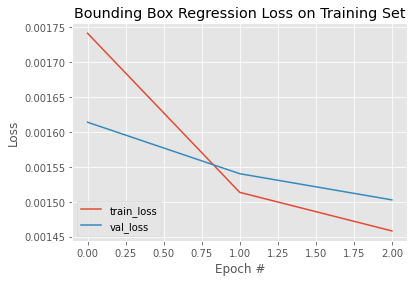

In [31]:
# serialize the model to disk
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = 3
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

In [32]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	print(interArea)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [33]:
from tensorflow.keras.models import load_model
model = load_model('/content/output/detector.h5')

In [34]:

with open('pools_ground_truth_upright.json','r') as f:
  ground_truth = json.load(f)

def predict(imagePath):
  image = load_img(imagePath, target_size=(150, 150))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)
    # make bounding box predictions on the input image
  preds = model.predict(image)[0]
  (x1,y1,x4,y4) = preds
  # load the input image (in OpenCV format), resize it such that it
  # fits on our screen, and grab its dimensions
  image = cv2.imread(imagePath)
  #image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]

  ## plot predicted bbox
  x1 = int(x1*w)
  y1 = int(y1*h)
  x4 = int(x4*w)
  y4 = int(y4*h)


  pts1 = [[x1,y1],[x4,y4]]
  
  cv2.rectangle(image, (x1, y1), (x4, y4),(0, 255, 0), 2)

  ## plot original bbox
  for t in ground_truth:
    for k, v in t.items():
      if k == imagePath.split('/')[1]:
        coors = v
  
  x1,y1 = coors[0][0], coors[0][1]
  x4,y4 = coors[1][0], coors[1][1]

  pts2 = [[x1,y1],[x4,y4]]
  
    
  return np.array(get_bounding_box(pts1)).flatten(), np.array(get_bounding_box(pts2)).flatten()

In [35]:
scores = []

In [36]:
with open("output/test_images.txt", 'r') as f:
  for line in f:
    pts1,pts2 = predict(f"images/{line.strip()}")
    v = bb_intersection_over_union(pts1, pts2)
    scores.append(v)


0
4520.250363367575
6933.133412847165
4575.063554757629
4675.296783869354
8091
5925
5624.000000000002
6391
6384
3304.7162098666054
5723.8231098430815
3515.449257168596
7396.101925786754
5184.000000000008
0
0
7104.000000000002
4836.787764705884
4302.786885245906
630
6700.2715654952135
5751.0
3107.3017456359075
7788.24051727973
4451.922268163028
6092.5234979179095
7743.0
3481.358490566038
5342.044858777916
6754.0145343924305
6022.5
5603.6338256776435
6080
3014.3751199846392
7350
5752.561085972848
4649.105094315407
3569.848560727214
3358.0975429264886
2831.8668565325775
6559.999999999997
6210
4217.5204092994045
4883.858823529412
5122.400000000001
1609.041776879095
5612.577311263629
7227.123287671227
5697.06128289582
5772.0
7189
6204.999999999997
5443.114017463591
4672.143953934735
6888
4327.838838869018
7189.000000000002
2855.5677131554603
3993.599999999999
5692.4810958904145
3918.197901502922
5801.1390825688095
2686.7581637482235
5037.970469798656
4880.55390549663
5547.999999999998
4484.

In [37]:
import numpy as np
from scipy.stats import binned_statistic

data = scores
bin_means = binned_statistic(data, data, bins=10, range=(0, 1))[0]

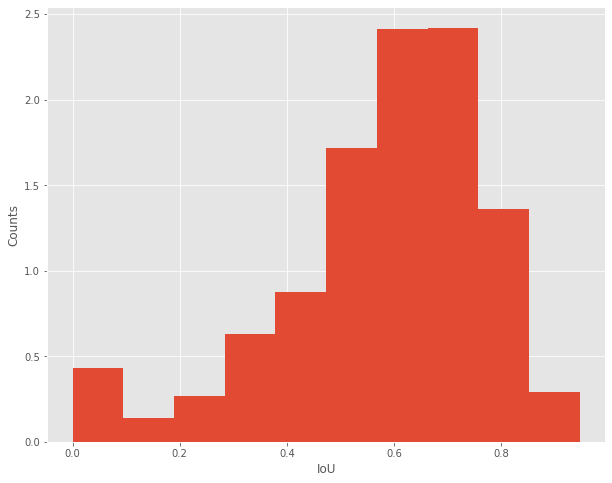

In [38]:
plt.figure(figsize=(10,8))
plt.hist(scores, density=True, bins=10)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('IoU');
plt.savefig('iou_metric.png')